# Attackees in Deep Learning

# Question 1

# A

## import required libaries

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import gc

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 10.6 MB/s eta 0:00:00


In [ ]:
# del variables
gc.collect()
torch.cuda.empty_cache()

## device agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## get dataset

In [ ]:
train_data = CIFAR10(root = 'data', train = True, transform = ToTensor(), download = True)
test_data = CIFAR10(root = 'data', train = False, transform = ToTensor(), download = True)
len(train_data), len(test_data)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


(50000, 10000)

## load data into data loader

In [ ]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

print(f"total {len(train_dataloader)} train dataloader of {BATCH_SIZE} batch size")
print(f"total {len(test_dataloader)} train dataloader of {BATCH_SIZE} batch size")

total 1562 train dataloader of 32 batch size
total 312 train dataloader of 32 batch size


## class name and its index

In [ ]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
class_idx = train_data.class_to_idx
class_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

##Visualize the image

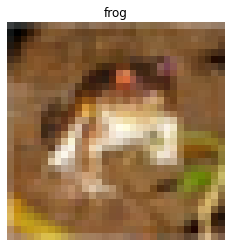

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)

image, lable = train_data[0]
# print(image, lable)
image = image.permute(1,2,0)
plt.imshow(image)
plt.title(class_names[lable])
plt.axis(False)
plt.show()

## Build model

In [ ]:
class CIFAR10CNN(nn.Module):
  def __init__(self, in_channel: int, out_channel: int, hidden_units: int, out_units: int):
    super().__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels = out_channel, out_channels = out_channel, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)
    )

    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels = out_channel, out_channels = out_channel, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)
    )

    self. flat = nn.Flatten()
    self.linear = nn.Sequential(
        nn.Linear(in_features = out_channel*32*32, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = out_units)
    )


  def forward(self, x):
    x = self.flat(self.conv_block3(self.conv_block2(self.conv_block1(x))))
    # print(x.shape)
    return self.linear(x)

base_model = CIFAR10CNN(in_channel = 3, out_channel = 10, hidden_units = 16, out_units = len(class_names)).to(device)
base_model

CIFAR10CNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=10240, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
)

## Loss and accuracy function

In [ ]:
# Loss 
loss_fn = nn.CrossEntropyLoss()

# accuracy
accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)

## FGSM Attack

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
  # Collect the element-wise sign of the data gradient
  sign_data_grad = data_grad.sign()
  # Create the perturbed image by adjusting each pixel of the input image
  perturbed_image = image + epsilon*sign_data_grad
  # Adding clipping to maintain [0,1] range
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  # Return the perturbed image
  return perturbed_image

## Train and Test loop

In [ ]:
# train
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, attack: bool, device: torch.device = device):
  
  train_loss, train_acc = 0, 0
  for batch, (x_train, y_train) in enumerate(dataloader):

    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device)

    x_train.requires_grad = True

    model.train()

    # 1. Forward step
    pred = model(x_train)

    # 2. Loss
    loss = loss_fn(pred, y_train)

    # 3. Grad zerostep
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    if attack:
      x_eval = fgsm_attack(x_train, 0.16, x_train.grad.data)
      pred = model(x_eval)

    acc = accuracy_fn(y_train, torch.argmax(pred, dim=1))
    train_loss += loss
    train_acc += acc

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


# test
def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, 
              device: torch.device = device):
  
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:

      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      # 1. Forward
      test_pred = model(x_test)
      
      # 2. Loss and accuray
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim=1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

## Model eval function

In [ ]:
def model_eval(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, device: torch.device = device):
  eval_loss, eval_acc = 0, 0
  # model.eval()
  # with torch.inference_mode():
  for x_eval, y_eval in dataloader:

    if device == 'cuda':
      x_eval, y_eval = x_eval.to(device), y_eval.to(device)


    x_eval.requires_grad = True

    model.train()

    # 1. Forward step
    pred = model(x_eval)

    # 2. Loss
    loss = loss_fn(pred, y_eval)

    # 3. Grad zerostep
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    x_eval = fgsm_attack(x_eval, 0.16, x_eval.grad.data)
    pred = model(x_eval)

    acc = accuracy_fn(y_eval, torch.argmax(pred, dim=1))
    eval_loss += loss
    eval_acc += acc

  eval_loss /= len(dataloader)
  eval_acc /= len(dataloader)

  return eval_loss, eval_acc

## Plot function for accuracy and loss

In [ ]:
def plot_graph(train_losses, test_losses, train_accs, test_accs):
  plt.figure(figsize = (20, 8))
  plt.subplot(1, 2, 1)
  plt.plot(range(len(train_losses)), train_losses, label = "Train Loss")
  plt.plot(range(len(test_losses)), test_losses, label = "Test Loss")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Loss")
  # plt.show()

  plt.subplot(1, 2, 2)
  plt.plot(range(len(train_accs)), train_accs, label = "Train Accuracy")
  plt.plot(range(len(test_accs)), test_accs, label = "Test Accuracy")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Accuracy")
  plt.show()

## train the base model

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
base_model = CIFAR10CNN(in_channel = 3, out_channel = 10, hidden_units = 16, out_units = len(class_names)).to(device)

# optimizer
optimizer = torch.optim.SGD(params = base_model.parameters(), lr = 0.017)
# optimizer = torch.optim.Adam(params = base_model.parameters(), lr = 0.0001)


base_train_loss, base_test_loss = [], []
base_train_accs, base_test_accs = [], []
epoches = 5

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = base_model, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer,
                                     accuracy_fn = accuracy_fn, attack = False,
                                     device = device)
  
  test_loss, test_acc = test_loop(model = base_model, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  base_train_loss.append(train_loss.item())
  base_test_loss.append(test_loss.item())
  base_train_accs.append(train_acc.item())
  base_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 2.0842 | Test Loss: 1.8766 | Train Accuray: 0.1597 | Test Accuracy: 0.2557
Epoch: 2  Train Loss: 1.5811 | Test Loss: 1.4240 | Train Accuray: 0.4079 | Test Accuracy: 0.4691
Epoch: 3  Train Loss: 1.4020 | Test Loss: 1.3565 | Train Accuray: 0.4803 | Test Accuracy: 0.4736
Epoch: 4  Train Loss: 1.3021 | Test Loss: 1.2784 | Train Accuray: 0.5189 | Test Accuracy: 0.5201
Epoch: 5  Train Loss: 1.2335 | Test Loss: 1.2550 | Train Accuray: 0.5442 | Test Accuracy: 0.5446


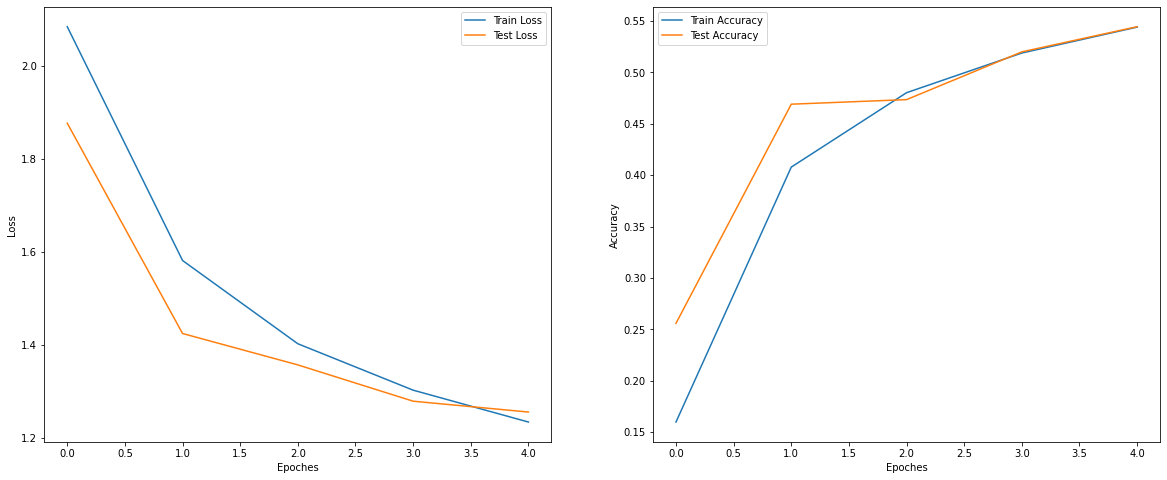

In [ ]:
plot_graph(base_train_loss, base_test_loss, base_train_accs, base_test_accs)

## FGSM attack

In [ ]:
attack_loss_list, attack_acc_list = [], []

epoches = 5

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  attack_loss, attack_acc = model_eval(model = base_model, dataloader = test_dataloader,
                                       loss_fn = loss_fn, optimizer = optimizer, 
                                       accuracy_fn = accuracy_fn, device = device)

  attack_loss_list.append(attack_loss.item())
  attack_acc_list.append(attack_acc.item())

  print(f"Epoch: {epoch+1}  Loss: {attack_loss:.4f} | Accuracy: {attack_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Loss: 1.2197 | Accuracy: 0.0013
Epoch: 2  Loss: 1.1710 | Accuracy: 0.0022
Epoch: 3  Loss: 1.1356 | Accuracy: 0.0020
Epoch: 4  Loss: 1.1061 | Accuracy: 0.0015
Epoch: 5  Loss: 1.0778 | Accuracy: 0.0013


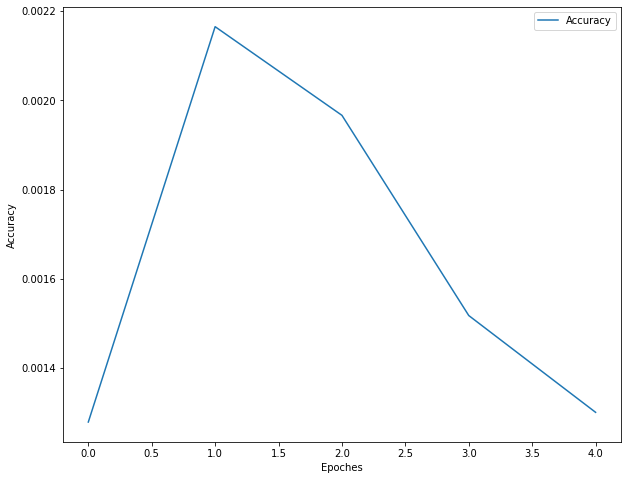

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(range(len(attack_acc_list)), attack_acc_list, label = "Accuracy")
plt.legend()
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.show()

# B

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import models
from torchvision.datasets import SVHN
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

In [ ]:
gc.collect()
torch.cuda.empty_cache()

## device agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## get dataset

In [ ]:
transform =  transforms.Compose([
                                    transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])

In [ ]:
train_data = SVHN(root = 'data', split = 'train', transform = transforms.ToTensor(), download = True)
test_data = SVHN(root = 'data', split = 'test', transform = transforms.ToTensor(), download = True)

len(train_data), len(test_data)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

(73257, 26032)

In [ ]:
prun_train_data = torch.utils.data.Subset(train_data, range(0, len(train_data), 8))
prun_test_data = torch.utils.data.Subset(test_data, range(0, len(test_data), 13))

In [ ]:
len(prun_train_data), len(prun_test_data)

(9158, 2003)

## Make dataloader

In [ ]:
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset = prun_train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
test_dataloader = DataLoader(dataset = prun_test_data, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

print(f"total {len(train_dataloader)} train dataloader of {BATCH_SIZE} batch size")
print(f"total {len(test_dataloader)} train dataloader of {BATCH_SIZE} batch size")

total 572 train dataloader of 16 batch size
total 125 train dataloader of 16 batch size


In [ ]:
print(train_data[0])

(tensor([[[0.1294, 0.0588, 0.0588,  ..., 0.2824, 0.3216, 0.3490],
         [0.1098, 0.0549, 0.0549,  ..., 0.1569, 0.2627, 0.3255],
         [0.1569, 0.0706, 0.0627,  ..., 0.0902, 0.1373, 0.2824],
         ...,
         [0.3373, 0.3412, 0.3216,  ..., 0.4078, 0.4078, 0.4039],
         [0.3294, 0.3373, 0.3216,  ..., 0.4314, 0.4157, 0.4157],
         [0.3333, 0.3490, 0.3333,  ..., 0.4353, 0.4275, 0.4039]],

        [[0.1176, 0.0902, 0.0667,  ..., 0.2549, 0.3020, 0.3098],
         [0.1529, 0.0980, 0.0784,  ..., 0.1529, 0.2275, 0.3059],
         [0.1608, 0.0824, 0.0667,  ..., 0.1137, 0.1647, 0.2706],
         ...,
         [0.3176, 0.3216, 0.3098,  ..., 0.4078, 0.4118, 0.4118],
         [0.3373, 0.3098, 0.2980,  ..., 0.4039, 0.4118, 0.4078],
         [0.3451, 0.3216, 0.3098,  ..., 0.4078, 0.4118, 0.4157]],

        [[0.1490, 0.0745, 0.0745,  ..., 0.2196, 0.2235, 0.2314],
         [0.1373, 0.0863, 0.0667,  ..., 0.1961, 0.2039, 0.2353],
         [0.1490, 0.1020, 0.0902,  ..., 0.1765, 0.1725, 0

## Take Resnet18 and VGG13 from pytorch

## Resnet18

In [ ]:
model_18 = models.resnet18(pretrained = True)
num_ftrs = model_18.fc.in_features
# print(num_ftrs)
model_18.fc = nn.Linear(num_ftrs, 10)
model_18 = model_18.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
## Loss, accuracy and optimizer
# Loss 
loss_fn = nn.CrossEntropyLoss()

# accuracy
accuracy_fn = MulticlassAccuracy(num_classes = 10).to(device)

# optimizer
optimizer = torch.optim.SGD(params = model_18.parameters(), lr = 0.001)

In [ ]:
model18_train_loss, model18_test_loss = [], []
model18_train_accs, model18_test_accs = [], []
epoches = 3

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = model_18, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer,
                                     accuracy_fn = accuracy_fn, attack = False,
                                     device = device)
  
  test_loss, test_acc = test_loop(model = model_18, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  model18_train_loss.append(train_loss.item())
  model18_test_loss.append(test_loss.item())
  model18_train_accs.append(train_acc.item())
  model18_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 2.0282 | Test Loss: 1.7734 | Train Accuray: 0.1935 | Test Accuracy: 0.2608
Epoch: 2  Train Loss: 1.4831 | Test Loss: 1.3169 | Train Accuray: 0.3775 | Test Accuracy: 0.3939
Epoch: 3  Train Loss: 1.1897 | Test Loss: 1.1115 | Train Accuray: 0.4750 | Test Accuracy: 0.4697


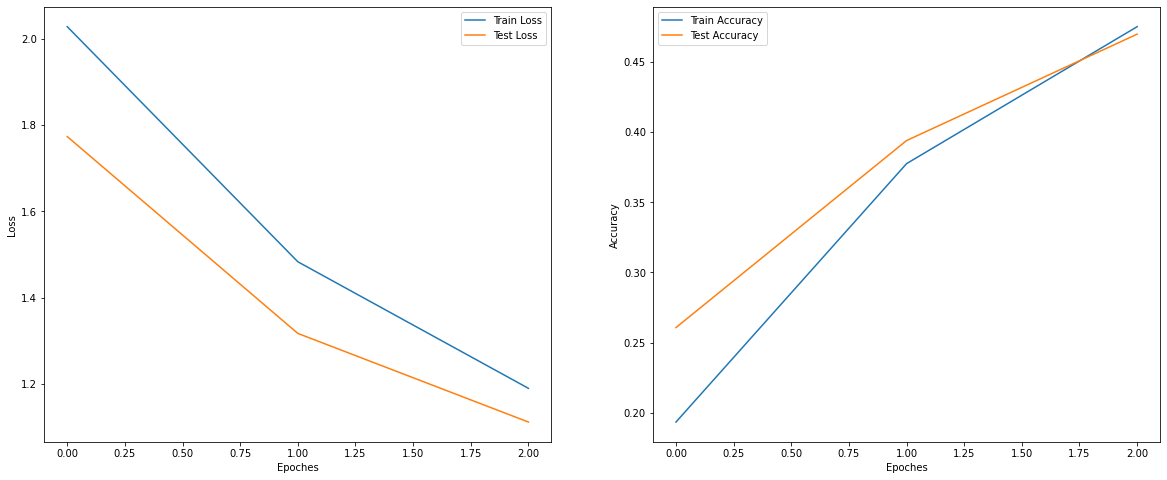

In [ ]:
plot_graph(model18_train_loss, model18_test_loss, model18_train_accs, model18_test_accs)

In [ ]:
# from torchvision import models
# model_18_api = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)

In [ ]:
!pip install -q torchattacks
import torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.9/155.9 KB 5.7 MB/s eta 0:00:00


In [ ]:
pgd_attack = torchattacks.PGD(model_18, eps=8/255, alpha=1/255, steps=10, random_start=True)

### PGD Attack

In [ ]:
def model_eval_PGD(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
                   accuracy_fn, device: torch.device = device):
  eval_loss, eval_acc = 0, 0
  # model.eval()
  # with torch.inference_mode():
  for x_eval, y_eval in dataloader:

    if device == 'cuda':
      x_eval, y_eval = x_eval.to(device), y_eval.to(device)


    # x_eval.requires_grad = True

    model.train()

    # # 1. Forward step
    # pred = model(x_eval)

    # # 2. Loss
    # loss = loss_fn(pred, y_eval)

    # # 3. Grad zerostep
    # optimizer.zero_grad()

    # # 4. Backward
    # loss.backward()

    # # 5. Optimizer step
    # optimizer.step()

    adv_images = pgd_attack(x_eval, y_eval)
    pred = model(adv_images)

    loss = loss_fn(pred, y_eval)
    acc = accuracy_fn(y_eval, torch.argmax(pred, dim=1))
    eval_loss += loss
    eval_acc += acc

  eval_loss /= len(dataloader)
  eval_acc /= len(dataloader)

  return eval_loss, eval_acc

In [ ]:
PGD18_loss_list, PGD18_acc_list = [], []

epoches = 5

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  PGD18_loss, PGD18_acc = model_eval_PGD(model = model_18, dataloader = test_dataloader,
                                         loss_fn = loss_fn, optimizer = optimizer, 
                                         accuracy_fn = accuracy_fn, device = device)

  PGD18_loss_list.append(PGD18_loss.item())
  PGD18_acc_list.append(PGD18_acc.item())

  print(f"Epoch: {epoch+1}  Loss: {PGD18_loss:.4f} | Accuracy: {PGD18_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Loss: 4.5745 | Accuracy: 0.0293
Epoch: 2  Loss: 4.6581 | Accuracy: 0.0283
Epoch: 3  Loss: 4.6939 | Accuracy: 0.0261
Epoch: 4  Loss: 4.6495 | Accuracy: 0.0303
Epoch: 5  Loss: 4.6119 | Accuracy: 0.0274


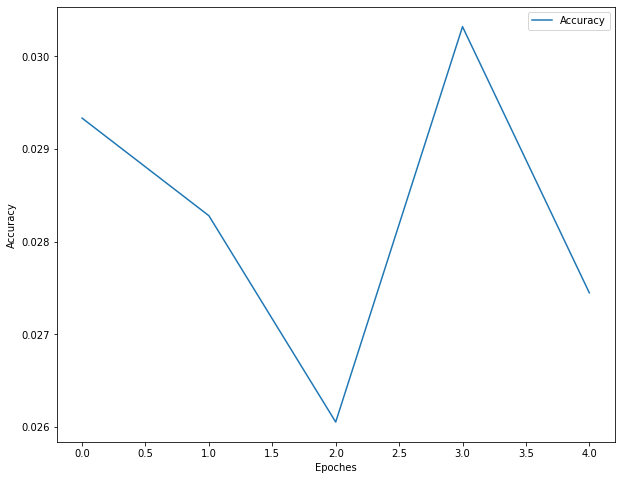

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(range(len(PGD18_acc_list)), PGD18_acc_list, label = "Accuracy")
plt.legend()
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.show()

### GN Attack

In [ ]:
gn_attack = torchattacks.GN(model_18)

In [ ]:
def model_eval_GN(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
                   accuracy_fn, device: torch.device = device):
  eval_loss, eval_acc = 0, 0
  # model.eval()
  # with torch.inference_mode():
  for x_eval, y_eval in dataloader:

    if device == 'cuda':
      x_eval, y_eval = x_eval.to(device), y_eval.to(device)


    # x_eval.requires_grad = True

    model.train()

    # # 1. Forward step
    # pred = model(x_eval)

    # # 2. Loss
    # loss = loss_fn(pred, y_eval)

    # # 3. Grad zerostep
    # optimizer.zero_grad()

    # # 4. Backward
    # loss.backward()

    # # 5. Optimizer step
    # optimizer.step()

    adv_images = gn_attack(x_eval, y_eval)
    pred = model(adv_images)

    loss = loss_fn(pred, y_eval)
    acc = accuracy_fn(y_eval, torch.argmax(pred, dim=1))
    eval_loss += loss
    eval_acc += acc

  eval_loss /= len(dataloader)
  eval_acc /= len(dataloader)

  return eval_loss, eval_acc

In [ ]:
GN18_loss_list, GN18_acc_list = [], []

epoches = 5

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  GN18_loss, GN18_acc = model_eval_GN(model = model_18, dataloader = test_dataloader,
                                      loss_fn = loss_fn, optimizer = optimizer, 
                                      accuracy_fn = accuracy_fn, device = device)

  GN18_loss_list.append(GN18_loss.item())
  GN18_acc_list.append(GN18_acc.item())

  print(f"Epoch: {epoch+1}  Loss: {GN18_loss:.4f} | Accuracy: {GN18_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Loss: 1.5903 | Accuracy: 0.3844
Epoch: 2  Loss: 1.5732 | Accuracy: 0.3856
Epoch: 3  Loss: 1.5973 | Accuracy: 0.3838
Epoch: 4  Loss: 1.6107 | Accuracy: 0.3737
Epoch: 5  Loss: 1.5887 | Accuracy: 0.3788


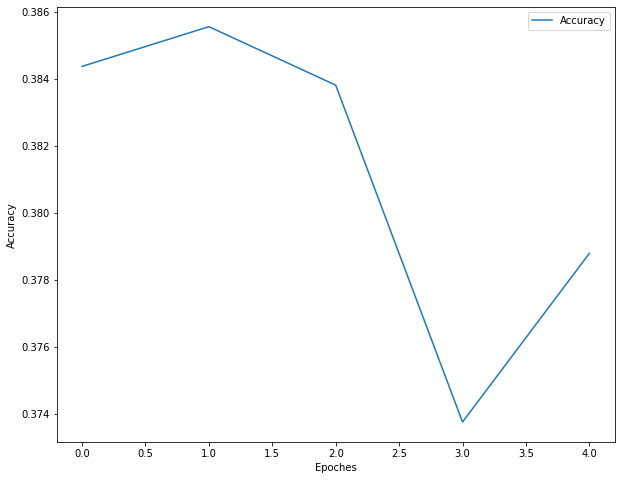

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(range(len(GN18_acc_list)), GN18_acc_list, label = "Accuracy")
plt.legend()
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.show()

## VGG13

In [ ]:
model_vgg = models.vgg16(pretrained = True)
# num_ftrs = model_vgg.fc.in_features
# print(num_ftrs)
number_of_features =  model_vgg.classifier[-1].in_features
model_vgg.classifier[6] = nn.Linear(number_of_features, 10)
model_vgg = model_vgg.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
## Loss, accuracy and optimizer
# Loss 
loss_fn = nn.CrossEntropyLoss()

# accuracy
accuracy_fn = MulticlassAccuracy(num_classes = 10).to(device)

# optimizer
optimizer = torch.optim.SGD(params = model_vgg.parameters(), lr = 0.001)

In [ ]:
modelvgg_train_loss, modelvgg_test_loss = [], []
modelvgg_train_accs, modelvgg_test_accs = [], []
epoches = 3

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = model_vgg, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer,
                                     accuracy_fn = accuracy_fn, attack = False,
                                     device = device)
  
  test_loss, test_acc = test_loop(model = model_vgg, dataloader = test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  modelvgg_train_loss.append(train_loss.item())
  modelvgg_test_loss.append(test_loss.item())
  modelvgg_train_accs.append(train_acc.item())
  modelvgg_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 1.6224 | Test Loss: 0.9643 | Train Accuray: 0.2755 | Test Accuracy: 0.4888
Epoch: 2  Train Loss: 0.8993 | Test Loss: 0.7135 | Train Accuray: 0.5107 | Test Accuracy: 0.5476
Epoch: 3  Train Loss: 0.6704 | Test Loss: 0.5821 | Train Accuray: 0.5908 | Test Accuracy: 0.6320


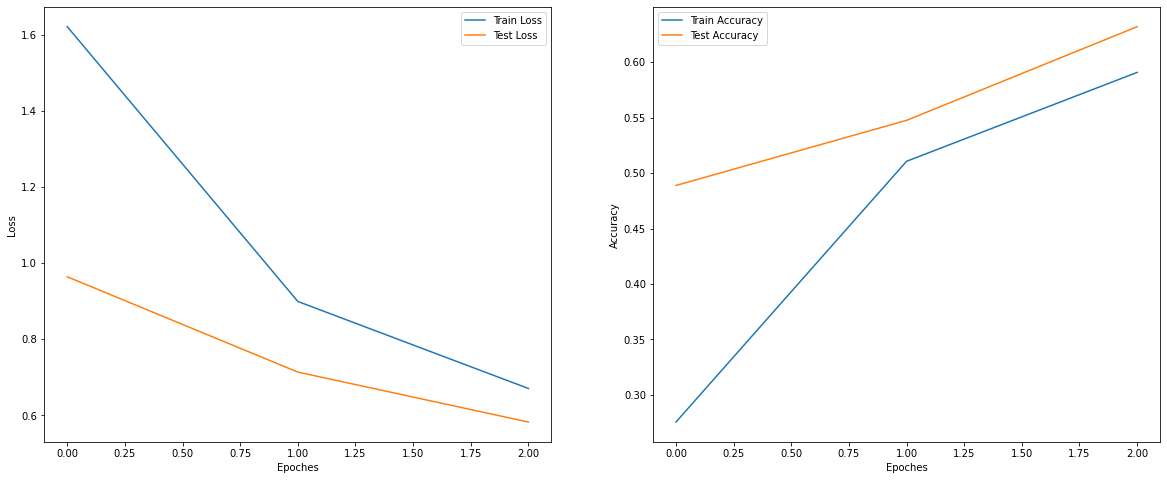

In [ ]:
plot_graph(modelvgg_train_loss, modelvgg_test_loss, modelvgg_train_accs, modelvgg_test_accs)

### PGD Attack

In [ ]:
PGDvgg_loss_list, PGDvgg_acc_list = [], []

epoches = 5

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  PGDvgg_loss, PGDvgg_acc = model_eval_PGD(model = model_vgg, dataloader = test_dataloader,
                                         loss_fn = loss_fn, optimizer = optimizer, 
                                         accuracy_fn = accuracy_fn, device = device)

  PGDvgg_loss_list.append(PGDvgg_loss.item())
  PGDvgg_acc_list.append(PGDvgg_acc.item())

  print(f"Epoch: {epoch+1}  Loss: {PGDvgg_loss:.4f} | Accuracy: {PGDvgg_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Loss: 1.0095 | Accuracy: 0.5083
Epoch: 2  Loss: 0.9961 | Accuracy: 0.5149
Epoch: 3  Loss: 1.0090 | Accuracy: 0.5195
Epoch: 4  Loss: 1.0157 | Accuracy: 0.5116
Epoch: 5  Loss: 1.0217 | Accuracy: 0.5174


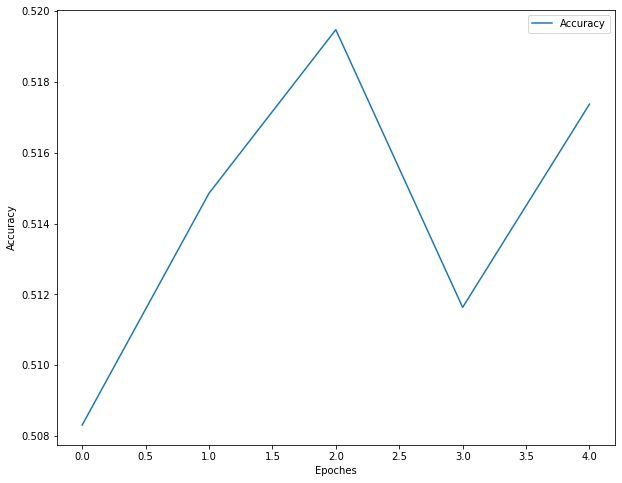

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(range(len(PGDvgg_acc_list)), PGDvgg_acc_list, label = "Accuracy")
plt.legend()
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.show()

### GN Attack

In [ ]:
GNvgg_loss_list, GNvgg_acc_list = [], []

epoches = 5

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  GNvgg_loss, GNvgg_acc = model_eval_GN(model = model_vgg, dataloader = test_dataloader,
                                        loss_fn = loss_fn, optimizer = optimizer, 
                                        accuracy_fn = accuracy_fn, device = device)

  GNvgg_loss_list.append(GNvgg_loss.item())
  GNvgg_acc_list.append(GNvgg_acc.item())

  print(f"Epoch: {epoch+1}  Loss: {GNvgg_loss:.4f} | Accuracy: {GNvgg_acc:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1  Loss: 1.9680 | Accuracy: 0.2689
Epoch: 2  Loss: 1.9539 | Accuracy: 0.2533
Epoch: 3  Loss: 1.9753 | Accuracy: 0.2481
Epoch: 4  Loss: 1.9754 | Accuracy: 0.2731
Epoch: 5  Loss: 1.9817 | Accuracy: 0.2596


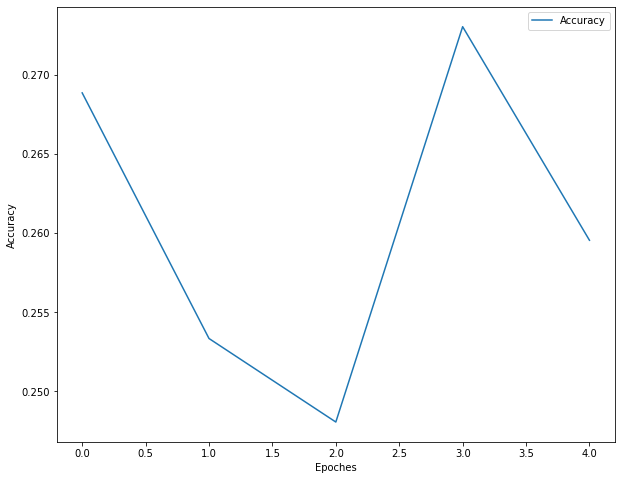

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(range(len(GNvgg_acc_list)), GNvgg_acc_list, label = "Accuracy")
plt.legend()
plt.xlabel("Epoches")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

# C

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import models
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
!pip install -q torchmetrics
!pip install -q torchattacks
import torchattacks
from torchmetrics.classification import MulticlassAccuracy

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Create Data Set

In [ ]:
train_data = CIFAR10(root = 'data', train = True, transform = ToTensor(), download = True)
test_data = CIFAR10(root = 'data', train = False, transform = ToTensor(), download = True)

len(train_data), len(test_data)

Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

In [ ]:
prun_train_data = torch.utils.data.Subset(train_data, range(0, len(train_data), 5))
prun_test_data = torch.utils.data.Subset(test_data, range(0, len(test_data), 2))
len(prun_train_data), len(prun_test_data)

(10000, 5000)

In [ ]:
len(prun_train_data), len(prun_test_data)

(10000, 5000)

In [ ]:
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset = prun_train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
test_dataloader = DataLoader(dataset = prun_test_data, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

print(f"total {len(train_dataloader)} train dataloader of {BATCH_SIZE} batch size")
print(f"total {len(test_dataloader)} train dataloader of {BATCH_SIZE} batch size")

total 625 train dataloader of 16 batch size
total 312 train dataloader of 16 batch size


In [ ]:
# Loss 
loss_fn = nn.CrossEntropyLoss()

# accuracy
accuracy_fn = MulticlassAccuracy(num_classes = 10).to(device)

In [ ]:
base_model = CIFAR10CNN(in_channel = 3, out_channel = 10, hidden_units = 16, out_units = 10).to(device)
base_model

fgsm = torchattacks.FGSM(base_model, eps=0.2)

optimizer = torch.optim.SGD(params = base_model.parameters(), lr = 0.017)

## create adversarial data

In [ ]:

def create_train_data(model: torch.nn.Module, dataloader: torch.utils.data.dataloader,
                loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
                attack, device: torch.device = device):
  
  # eval_loss, eval_acc = 0, 0
  data = []

  for batch, (x_eval, y_eval) in enumerate(dataloader):

    if device == 'cuda':
      x_eval, y_eval = x_eval.to(device), y_eval.to(device)

    model.train()

    adv_images = attack(x_eval, y_eval)

    for i in adv_images:
      
        s_tuple = (i, torch.tensor(1).to(device))

        data.append(s_tuple)

  return data


def create_test_data(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
                   attack, device: torch.device = device):
 
  data = []
  for x_eval, y_eval in dataloader:

    if device == 'cuda':
      x_eval, y_eval = x_eval.to(device), y_eval.to(device)


    model.train()

    adv_images = attack(x_eval, y_eval)
  
  
    for i in adv_images:
      
        s_tuple = (i, torch.tensor(1).to(device))

        data.append(s_tuple)

  return data

In [ ]:
ad_train = create_train_data(base_model, train_dataloader, loss_fn, optimizer, fgsm, device)
ad_test = create_test_data(base_model, test_dataloader, loss_fn, optimizer, fgsm, device)

In [ ]:
len(ad_train), len(ad_test)

(10000, 4992)

In [ ]:
train_list = []

for x, y in prun_train_data:
  s_tuple = (x.to(device), torch.tensor(0).to(device))
  train_list.append(s_tuple)

test_list = []
for x, y in prun_test_data:
  s_tuple = (x.to(device), torch.tensor(0).to(device))
  test_list.append(s_tuple)

In [ ]:
len(train_list), len(test_list)

(10000, 5000)

In [ ]:
# concate datasets
new_train_data = torch.utils.data.ConcatDataset((train_list, ad_train))
new_test_data = torch.utils.data.ConcatDataset([test_list, ad_test])

In [ ]:
len(new_train_data), len(new_test_data)

(20000, 9992)

## Create dataloader

In [ ]:
BATCH_SIZE = 16
new_train_dataloader = DataLoader(dataset = new_train_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
new_test_dataloader = DataLoader(dataset = new_test_data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

print(f"total {len(train_dataloader)} train dataloader of {BATCH_SIZE} batch size")
print(f"total {len(test_dataloader)} train dataloader of {BATCH_SIZE} batch size")

total 625 train dataloader of 16 batch size
total 312 train dataloader of 16 batch size


## build model

In [ ]:
model_18 = models.resnet18(pretrained = True)
num_ftrs = model_18.fc.in_features
# print(num_ftrs)
model_18.fc = nn.Linear(num_ftrs, 2)
model_18 = model_18.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
## Loss, accuracy and optimizer
# Loss 
loss_fn = nn.CrossEntropyLoss()

# accuracy
accuracy_fn = MulticlassAccuracy(num_classes = 2).to(device)

# optimizer
optimizer = torch.optim.SGD(params = model_18.parameters(), lr = 0.001)

In [ ]:
model18_train_loss, model18_test_loss = [], []
model18_train_accs, model18_test_accs = [], []
epoches = 3

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = model_18, dataloader = new_train_dataloader,
                                     loss_fn = loss_fn, optimizer = optimizer,
                                     accuracy_fn = accuracy_fn, attack = False, device = device)
  
  test_loss, test_acc = test_loop(model = model_18, dataloader = new_test_dataloader,
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn,
                                  device = device)
  
  model18_train_loss.append(train_loss.item())
  model18_test_loss.append(test_loss.item())
  model18_train_accs.append(train_acc.item())
  model18_test_accs.append(test_acc.item())

  print(f"Epoch: {epoch+1}  Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Accuray: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1  Train Loss: 0.1100 | Test Loss: 0.0196 | Train Accuray: 0.9557 | Test Accuracy: 0.9960
Epoch: 2  Train Loss: 0.0256 | Test Loss: 0.0124 | Train Accuray: 0.9902 | Test Accuracy: 0.9975
Epoch: 3  Train Loss: 0.0163 | Test Loss: 0.0086 | Train Accuray: 0.9943 | Test Accuracy: 0.9991


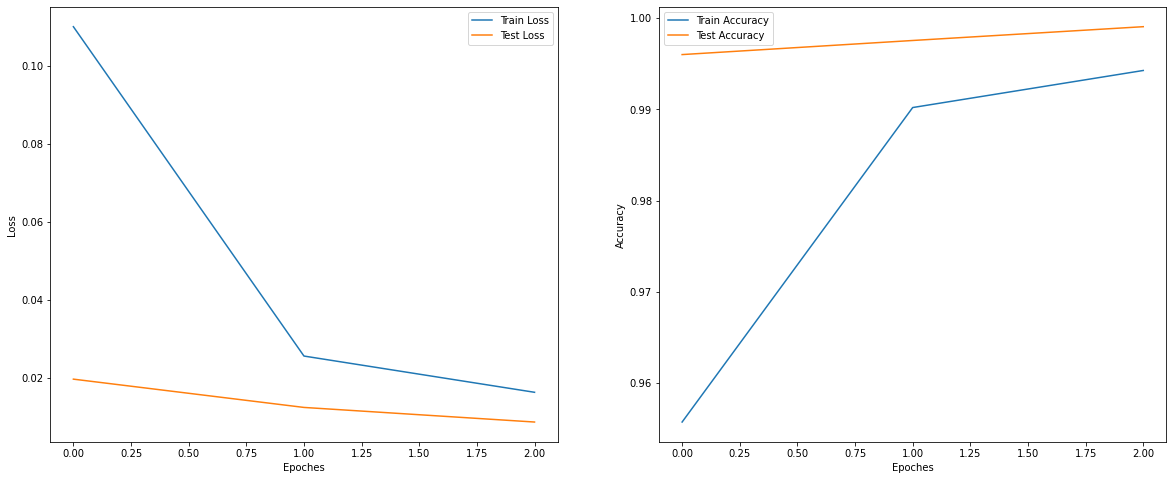

In [ ]:
plot_graph(model18_train_loss, model18_test_loss, model18_train_accs, model18_test_accs)

## Save Model

In [ ]:
# save model
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive/')

MODEL_PATH = Path("drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

MODEL_NAME = "ad_model.pth"
MODEL_PATH_SAVE = MODEL_PATH / MODEL_NAME

print(f"model saved at: {MODEL_PATH_SAVE}")
torch.save(obj = model_18.state_dict(), f = MODEL_PATH_SAVE)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
model saved at: drive/MyDrive/Course/Sem2/DAI/Assignments/Assignment1/ad_model.pth
